In [464]:
import tensorflow as tf
import numpy as np
import cv2
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

In [465]:
def grad_cam(model, image, category_index, layer_name):
    # 获取模型中的层
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, category_index]

    # 获取梯度
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    # 求梯度的全局平均值
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 计算特征图的加权平均
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, output), axis=-1)

    # 应用ReLU激活并归一化
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [466]:
# def grad_cam(model, image, category_index, layer_name):
#     grad_model = tf.keras.models.Model(
#         [model.inputs], [model.get_layer(layer_name).output, model.output]
#     )
# 
#     with tf.GradientTape() as tape:
#         conv_outputs, predictions = grad_model(image)
#         loss = predictions[:, category_index]
# 
#     grads = tape.gradient(loss, conv_outputs)[0]
#     pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
# 
#     heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs[0]), axis=-1)
#     heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
#     return heatmap.numpy()

In [467]:
weights = [2.25, 2.25, 1]  

def focal_loss_function(weights, gamma=2, eps=1e-7):
    weights = tf.constant(weights, dtype=tf.float32)

    def focal_loss(y_true, y_pred):
        y_pred = tf.reshape(y_pred, (tf.shape(y_pred)[0], tf.shape(y_pred)[1], -1))  
        target = tf.reshape(y_true, tf.shape(y_pred))  

        ce = -1 * tf.math.log(y_pred + eps) * target
        floss = tf.pow((1 - y_pred), gamma) * ce
        floss = floss * weights
        floss = tf.reduce_sum(floss, axis=1)
        return tf.reduce_mean(floss)

    return focal_loss


custom_focal_loss = focal_loss_function(weights)


def weighted_accuracy(weights):
    max_weight = max(weights)
    normalized_weights = [w / max_weight for w in weights]

    def accuracy(y_true, y_pred):
        true_class = K.argmax(y_true, axis=-1)
        pred_class = K.argmax(y_pred, axis=-1)
        accuracy = K.cast(K.equal(true_class, pred_class), 'float32')

        class_weights = K.gather(K.constant(normalized_weights), true_class)
        weighted_accuracy = K.sum(accuracy * class_weights) / K.sum(class_weights)

        return weighted_accuracy

    return accuracy


custom_acc = weighted_accuracy(weights)

In [468]:
custom_objects = {'focal_loss': custom_focal_loss, 'accuracy': custom_acc}

In [469]:
# 加载模型和图像
# model = tf.keras.models.load_model(r'D:\Download\MV_Coursework\Coursework\Code\figure\new_structure_inception\IAR.h5',custom_objects=custom_objects) # 你的模型
model = tf.keras.models.load_model(r'D:\Download\MV_Coursework\Coursework\Code\final_model\ensemble.h5',custom_objects=custom_objects) # 你的模型
# model = tf.keras.models.load_model(r'D:\Download\MV_Coursework\Coursework\Code\figure\new_ensemble\ensemble.h5',custom_objects=custom_objects) # 你的模型
# model = tf.keras.models.load_model(r'D:\Download\MV_Coursework\Coursework\Code\figure\new_structure_mobile\MAR.h5',custom_objects=custom_objects) # 你的模型
image_path = r"D:\Download\MV_Coursework\Coursework\Code\augmented_image\RGB_augmented_300_224\test\Healthy\loh(102).JPG"# 你的输入图像
# 加载模型
# 查看编译信息
# print("优化器：", model.optimizer)
# print("损失函数：", model.loss)
# print("评估指标：", model.metrics)
# 
# # 查看优化器配置（例如学习率）
# optimizer_config = model.optimizer.get_config()
# print("优化器配置：", optimizer_config)
# 
# # 如果使用的是特定优化器，如Adam，可以这样访问特定参数
# if 'learning_rate' in optimizer_config:
#     print("学习率：", optimizer_config['learning_rate'])
    
layer_name = 'conv2d_65'
category_index = 0# 你感兴趣的类别的索引
# conv2d_58
# conv2d_6
# conv2d_65
# 7,16,23,30,37,44,51,58,65
# 2,4,6

In [470]:
# 读取图像
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# 预处理图像
# 假设模型期望的输入尺寸是224x224
img = cv2.resize(img, (224, 224))
img = img / 255.0  # 归一化
img = img.astype('float32')  # 确保图像数据类型为float32
# 扩展维度以符合模型输入要求
img = np.expand_dims(img, axis=0)

In [471]:
image = [img,img]
# image = img

In [472]:
for layer in model.layers:
    print(layer.name)

input_2
conv2d_7
max_pooling2d
conv2d_8
conv2d_9
max_pooling2d_1
conv2d_11
conv2d_13
max_pooling2d_2
conv2d_10
conv2d_12
conv2d_14
conv2d_15
concatenate
global_average_pooling2d_4
reshape_3
dense_8
dense_9
conv2d_16
multiply_3
add_3
conv2d_18
conv2d_20
max_pooling2d_3
conv2d_17
conv2d_19
conv2d_21
conv2d_22
concatenate_1
global_average_pooling2d_5
reshape_4
dense_10
dense_11
conv2d_23
multiply_4
add_4
max_pooling2d_4
conv2d_25
conv2d_27
max_pooling2d_5
conv2d_24
conv2d_26
conv2d_28
conv2d_29
concatenate_2
global_average_pooling2d_6
reshape_5
dense_12
dense_13
conv2d_30
multiply_5
add_5
conv2d_32
conv2d_34
max_pooling2d_6
conv2d_31
conv2d_33
conv2d_35
conv2d_36
concatenate_3
global_average_pooling2d_7
reshape_6
dense_14
input_1
dense_15
conv2d
conv2d_37
multiply_6
batch_normalization
add_6
activation
conv2d_39
conv2d_41
max_pooling2d_7
depthwise_conv2d
conv2d_38
conv2d_40
conv2d_42
conv2d_43
batch_normalization_1
concatenate_4
activation_1
global_average_pooling2d_8
conv2d_1
reshape_7
b

In [473]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 112, 112, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 56, 56, 64)   0           ['conv2d_7[0][0]']               
                                                                                            

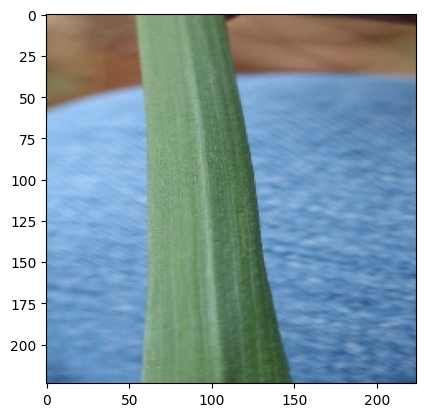

In [474]:
from tensorflow.python.keras.preprocessing.image import load_img
image1 = np.array(load_img(image_path, target_size=(224, 224, 3)))
plt.imshow(image1)

In [475]:
# 计算Grad-CAM
heatmap = grad_cam(model, image, category_index, layer_name)
# 将热力图叠加在原始图像上
img = cv2.imread(image_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
# 保存结果图像
cv2.imwrite('grad_cam.jpg', superimposed_img)

True